## 개선된 U-net 만들기 

---



### Semantic Segmentation dataset

---


#### load image, data
- 도로영역을 분리하기 위해 도로 영역을 라벨로 가진 데이터셋을 필요
- 학습 할 수 있도록 파싱 필요 
- kitti dataset segmentation data 사용 

#### data loader
- 모델을 학습시킬 수 있는 data loader 를 만든다 
- input (224,224) , output(224,224) 크기를 갖는 모델을 학습 시킬 수 있도록 데이터 파싱
- augmentation 을 적용 : albumentations 
- 일정 량을 validation dataset 으로 사용 


In [ ]:
import os 
os.environ['HOME'] = '/content/drive/MyDrive'
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [ ]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train :
    return Compose([
                    HorizontalFlip(p=0.5),
                    RandomSizedCrop(
                        min_max_height=(300,370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                    ),
                    Resize(
                        width=224,
                        height=224
                    )
    ])
  return Compose([
                    Resize(
                        width=224,
                        height=224
                    )
    ])

In [ ]:
dir_path = os.getenv('HOME') + '/data/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path,'image_2','*.png'))

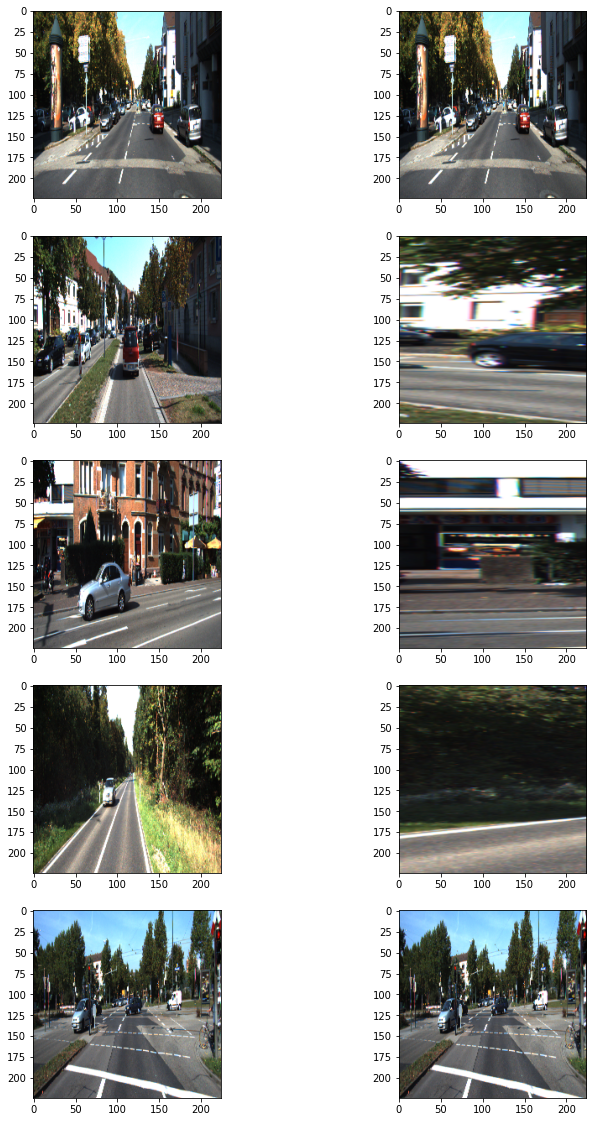

In [ ]:
plt.figure(figsize=(12,20))
for i in range(5):
  image = imread(input_images[i])
  image_data = {'image':image}
  resized = augmentation_test(**image_data)
  processed = augmentation_train(**image_data)
  plt.subplot(5,2,2*i+1)
  plt.imshow(resized['image'])
  plt.subplot(5,2,2*i+2)
  plt.imshow(processed['image'])

plt.show()

- 데이터셋 구성 
   - generator 형태로 구성 (using tf.keras.utils.Sequence를 상속)

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self,
               dir_path,
               batch_size=16,
               img_size=(224,224,3),
               output_size=(224,224),
               is_train=True,
               augmentation=None):
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset 의 directory path 에서 라벨과 이미지 확인 
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset 에서 필요한 정보(image path, label)을 directory 에서 확인하고 로드
    # 이 때 is train 여부에 따라 test set 을 분리해서 load 
    input_images = glob(os.path.join(self.dir_path,'image_2','*.png'))
    label_images = glob(os.path.join(self.dir_path,'semantic','*.png'))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [_ for _ in zip(input_images,label_images)]

    if self.is_train :
      return data[:-30]
    return data[-30:]

  def __len__(self):
    # generator 의 length : 전체dataset 을 batch_size 로 나누고 올림 
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self,index):
    # 입출력 만듬 
    # input = resize 와 augmentation 적용된 input image
    # output = semantic label
    batch_data = self.data[
                            index*self.batch_size:(index + 1)*self.batch_size
    ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])

    for i,data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          'image' : _input,
          'mask' : _output,
      }
      augmented = self.augmentation(**data)
      inputs[i] = augmented['image']/255
      outputs[i] = augmented['mask']
      return inputs, outputs

  def on_epoch_end(self):
    # 한 에폭이 끝날 때 마다 random shuffle 실행하는 함수 
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,augmentation=test_preproc,is_train=False)

### U-net building for semantic segmentation

---



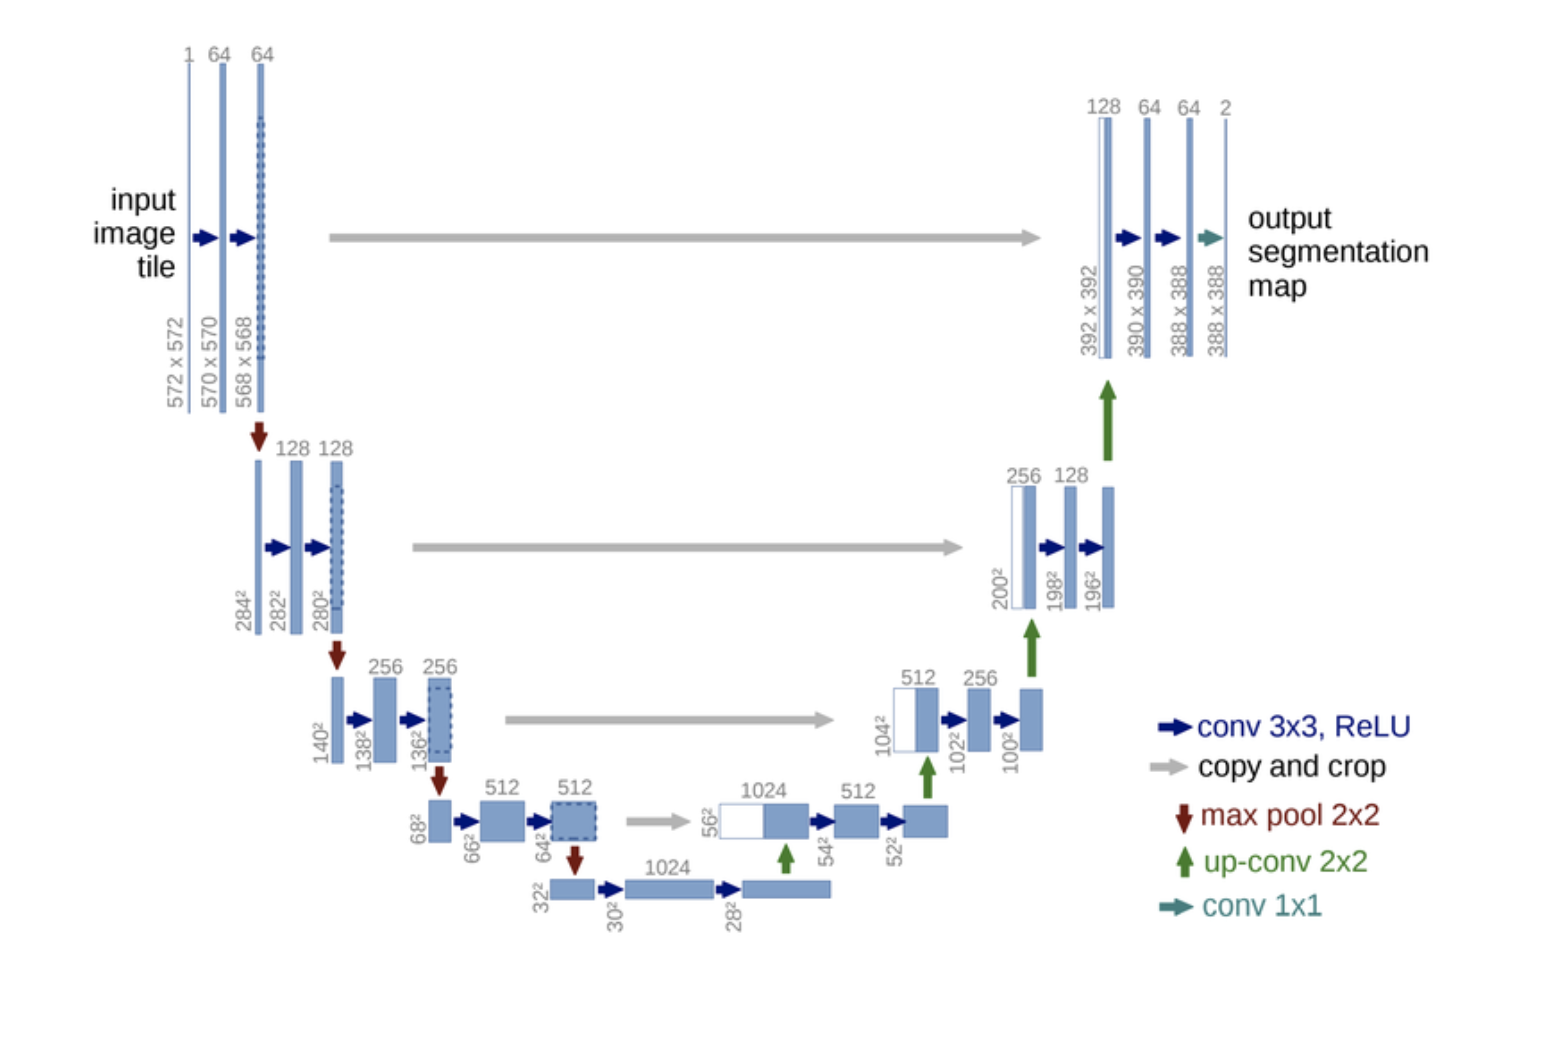

- network 구조가 u 자 형태를 띔 
- fcn 에서 upsampling 을 통해 특성 맵을 키운 것을 입력값과 대칭적으로 만들어줌 
- Contracting path 에서 conv-relu 두번 거친 후 maxpooling (for downsample)
- Expansive path 에서 upsampling 으로 채널 절반으로줄어듬, 특성맵의 크기는 늘어남 + conv-relu 두번
- output 을 위해 conv-sigmoid 거침 

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model


In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# model_path = os.getenv('HOME') + '/data/semantic_segmentation/seg_model_unet.h5'

# model = build_model()
# model.compile(optimizer = Adam(1e-4),
#               loss = 'binary_crossentropy')
# model.fit(
#     train_generator,
#     validation_data = test_generator,
#     steps_per_epoch = len(train_generator),
#     epochs=100
# )

# model.save(model_path)

- 모델을 따로 학습 시키지는 않고 이미 학습 된 모델이 있어 불러옴 

In [ ]:
model_path = dir_path + '/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

### Semantic segmentation model visualize

---



- 테스트셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인 할 수 있도록 모델이 추론 한 결과를 시각화
- 입력 이미지와 라벨을 함께 볼 수 있도록 모델의 출력값을 이미지 위에 겹쳐 보이기 (overray) 한다 (using Image.blend)

In [ ]:
def get_output(model,preproc,image_path,output_path):
  origin_img = imread(image_path)
  data = {'image':origin_img}
  processed = preproc(**data)
  output = model(np.expand_dims(processed['image']/255,axis=0))
  output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA')
  output = Image.blend(background,output,alpha=0.5)
  output.show()

  return output

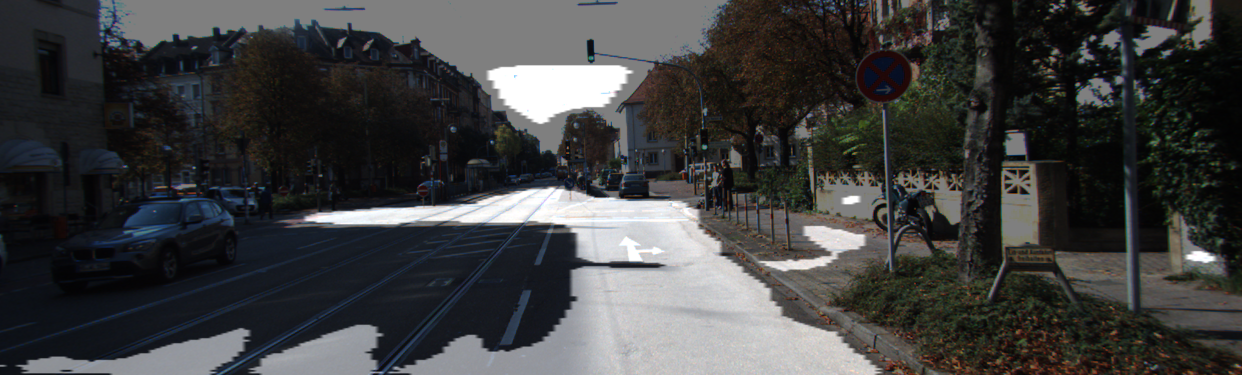

In [ ]:
i = 1
get_output(model,
           test_preproc,
           image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
           output_path = dir_path + f'./result_{str(i).zfill(3)}.png')

- segmentation 성능을 정량적으로 측정하기 위한 방법 : IoU 계산 
- 모델이 도로 영역이라고 판단한 부분이 1, 나머지 부분이 0 인 행렬 과 라벨 데이터에서 도로는 1  나머지는 0 으로 표시된 행렬이 필요하다 각각을 prediction, target 으로 정의한다 

In [ ]:
def calculate_iou_score(target,prediction):
  intersection = np.logical_and(target,prediction)
  union = np.logical_or(target,prediction)
  iou_score = float(np.sum(intersection))/float(np.sum(union))
  print('IoU : %f' % iou_score)
  return iou_score

In [ ]:
def get_output(model,preproc,image_path,output_path,label_path):
  origin_img = imread(image_path)
  data = {'image':origin_img}
  processed = preproc(**data)
  output = model(np.expand_dims(processed['image']/255,axis=0))
  output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
  prediction = output/255

  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA')
  output = Image.blend(background,output,alpha=0.5)
  output.show()

  if label_path :
    label_img = imread(label_path)
    label_data = {'image':label_img}
    label_processed = preproc(**label_data)
    label_processed = label_processed['image']
    target = (label_processed ==7).astype(np.uint8)*1

    return output,prediction,target
  else : 
    return output, prediction, _



In [ ]:
i = 1
output,prediction,target = get_output(
    model,
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target,prediction)

IoU : 0.419641


0.41964089410040306

### 개선된 U-net++ 모델 만들기 

---



#### Step 1. Kitti dataset 수집과 구축 

- 위에서 정의한 함수를 통해 kitti data 에 data augmentation 적용한 형태로 데이터셋 구축 

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path,augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,augmentation=test_preproc,is_train=False)

#### Step 2. Unet++ 모델의 구현

---


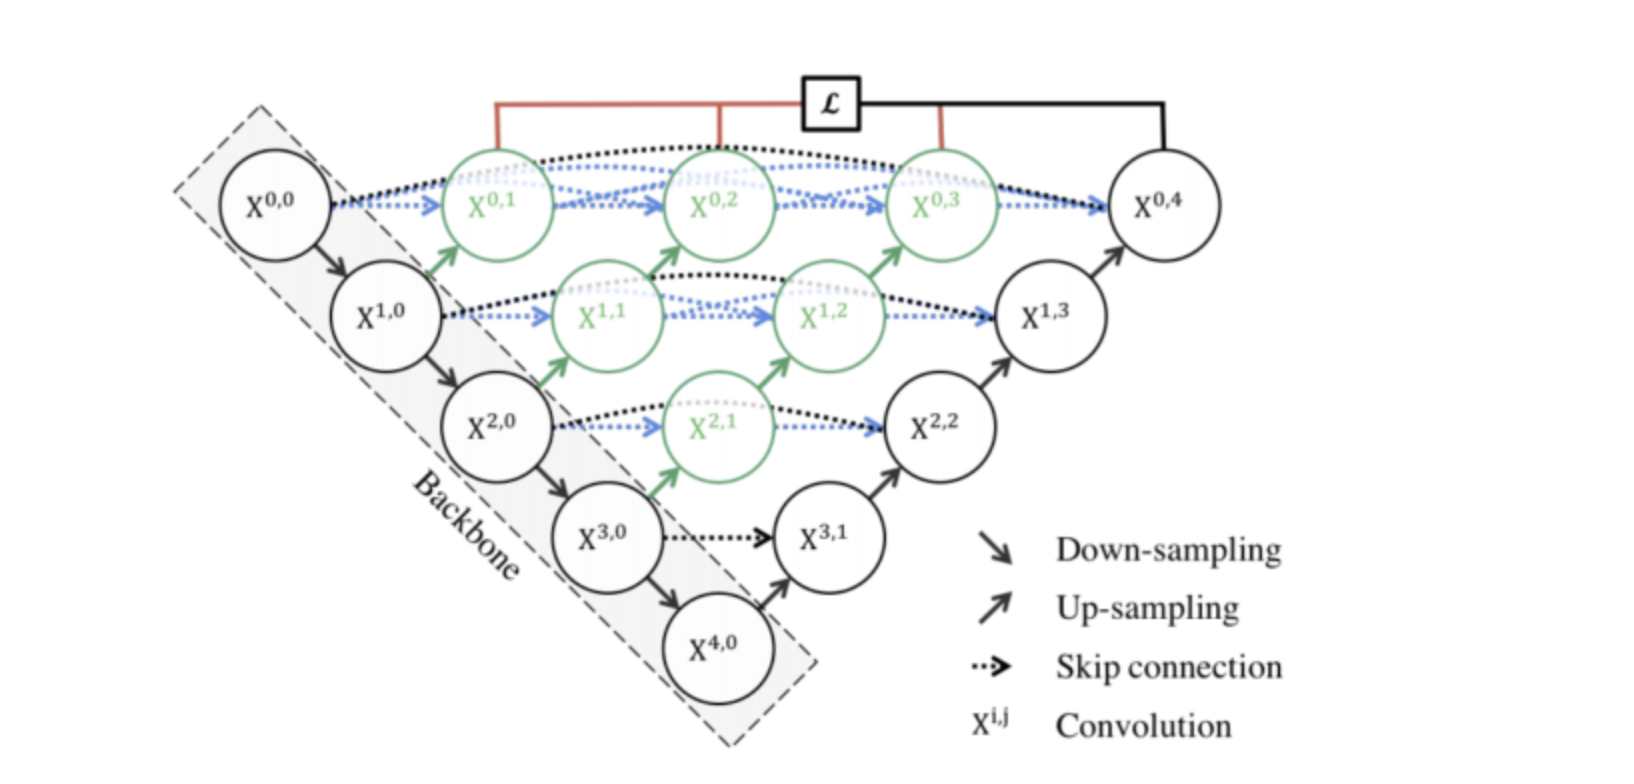

- 각 동그라미(노드) 별로 레이어를 구현했다. 
- 그림의 x 는 0 부터 시작하지만, 레이어의 번호를 1 부터 매겼다 
- 즉 작성한 코드의 #x1_1 레이어는 그림에서 X0_0 에 해당한다 (왜 이렇게 했는지 모르겠다..)
- 그림의 설명 대로 각 동그라미는 두번의 CONV- RELU 를 거친다
- 화살표의 방향에 따라 
  - Down sampling 일 경우 maxpool
  - up sampling 일 경우 transpose2D또는 upsample2D 레이어를 사용 할 수 있지만 , transpose 선택 
  - skip connection 일 경우 concatenate , axis = 3 
- output 은 x0_4(x1_5) 에 x0_1(x1_2),x0_2(x1_3),x0_3(x1_4) 를 모두 받아 conv-sigmoid 거치지만 , deep supervision 이 아닌 경우 output 으로 x0_4(x1_5) 만 conv-sigmoid 거쳐 사용

In [ ]:
def build_unetplus(input_shape=(224,224,3),deep_supervision=True,batch_size=4):
  inputs = Input(input_shape)

  #Contracting Path
  #x1_1
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  #x2_1
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  #x1_2
  up1_2 = Conv2DTranspose(64,2,strides=2,padding='same')(conv2)
  conv1_2 = concatenate([up1_2,conv1],axis=3)
  conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
  conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)

  #x3_1
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  #x2_2
  up2_2 = Conv2DTranspose(128,2,strides=2,padding='same')(conv3)
  conv2_2 = concatenate([up2_2,conv2],axis=3)
  conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
  conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)

  #x1_3
  up1_3 = Conv2DTranspose(64,2,strides=2,padding='same')(conv2_2)
  conv1_3 = concatenate([up1_3,conv1,conv1_2],axis=3)
  conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
  conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)

  #x4_1
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  #x3_2
  up3_2 = Conv2DTranspose(256,2,strides=2,padding='same')(conv4)
  conv3_2 = concatenate([up3_2,conv3],axis=3)
  conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)
  conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)

  #x2_3
  up2_3 = Conv2DTranspose(128,2,strides=2,padding='same')(conv3_2)
  conv2_3 = concatenate([up2_3,conv2,conv2_2],axis=3)
  conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)
  conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)

  #x1_4
  up1_4 = Conv2DTranspose(64,2,strides=2,padding='same')(conv2_3)
  conv1_4 = concatenate([up1_4,conv1,conv1_2,conv1_3],axis=3)
  conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)
  conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)


  #x5_1
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  #Expanding Path
  #x4_2
  up4_2 = Conv2DTranspose(512,2,strides=2,padding='same')(conv5)
  conv4_2 = concatenate([up4_2,conv4],axis=3)
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)

  #x3_3
  up3_3 = Conv2DTranspose(256,2,strides=2,padding='same')(conv4_2)
  conv3_3 = concatenate([up3_3,conv3,conv3_2],axis=3)
  conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)
  conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)

  #x2_4
  up2_4 = Conv2DTranspose(128,2,strides=2,padding='same')(conv3_3)
  conv2_4 = concatenate([up2_4,conv2,conv2_2,conv2_3],axis=3)
  conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)
  conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)

  #x1_5
  up1_5 = Conv2DTranspose(64,2,strides=2,padding='same')(conv2_4)
  conv1_5 = concatenate([up1_5,conv1,conv1_2,conv1_3,conv1_4],axis=3)
  conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)
  conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)

  #
  output1 = Conv2D(1,1,activation='sigmoid')(conv1_2)
  output2 = Conv2D(1,1,activation='sigmoid')(conv1_3)
  output3 = Conv2D(1,1,activation='sigmoid')(conv1_4)
  output4 = Conv2D(1,1,activation='sigmoid')(conv1_5)

  if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1, output2, output3, output4])
  else:
        model = Model(inputs=inputs, outputs=output4)

  return model





In [ ]:
unet_plus = build_unetplus(deep_supervision=False)
unet_plus.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

- project 에서 제공한 github 링크 출처의 함수 가져옴 
- 그러나 deep supervised = False 인 상황 만 학습 시키므로 실질적으로 사용되지 않음 

In [ ]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
unet_plus.compile(optimizer = Adam(1e-4), loss='binary_crossentropy')
unet_plus.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
 )

unetpp_model_path = os.getenv('HOME') + '/data/semantic_segmentation/seg_model_unet_pp.h5'
unet_plus.save(unetpp_model_path)

Epoch 1/100
11/11 [==============================] - 52s 2s/step - loss: 0.6804 - val_loss: 0.6581
Epoch 2/100
11/11 [==============================] - 18s 2s/step - loss: 0.5850 - val_loss: 0.3190
Epoch 3/100
11/11 [==============================] - 18s 2s/step - loss: 0.0828 - val_loss: 0.0274
Epoch 4/100
11/11 [==============================] - 17s 2s/step - loss: 0.0337 - val_loss: 0.0292
Epoch 5/100
11/11 [==============================] - 18s 2s/step - loss: 0.0319 - val_loss: 0.0334
Epoch 6/100
11/11 [==============================] - 18s 2s/step - loss: 0.0276 - val_loss: 0.0290
Epoch 7/100
11/11 [==============================] - 18s 2s/step - loss: 0.0267 - val_loss: 0.0308
Epoch 8/100
11/11 [==============================] - 18s 2s/step - loss: 0.0349 - val_loss: 0.0345
Epoch 9/100
11/11 [==============================] - 18s 2s/step - loss: 0.0359 - val_loss: 0.0298
Epoch 10/100
11/11 [==============================] - 18s 2s/step - loss: 0.0300 - val_loss: 0.0269
Epoch 11/

In [ ]:
seg_model_unet_pp_notsuper = tf.keras.models.load_model(unetpp_model_path)

In [ ]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     seg_model_unet_pp_notsuper, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
calculate_iou_score(target, prediction)

IoU : 0.803074


0.8030736240171551

#### Step 3. unet 과 unet++ 모델이 수행한 segmentation 결과 분석 

---

- 두 모델의 정량적,정성적 성능 비교
- 시각화, IoU 계산 등 체계적으로 시도 

In [ ]:
unet_model = tf.keras.models.load_model(model_path)
unetpp_model = tf.keras.models.load_model(unetpp_model_path)

In [ ]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    
    return output

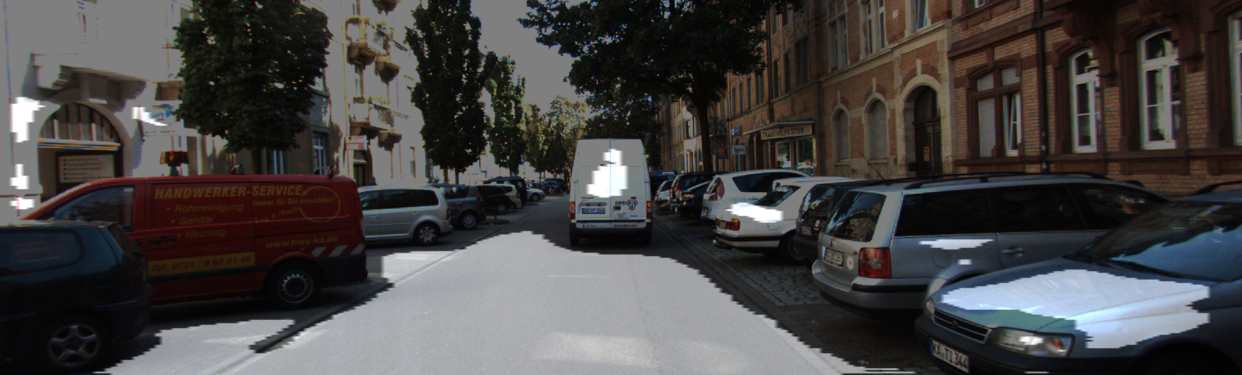

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 

# U-Net
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

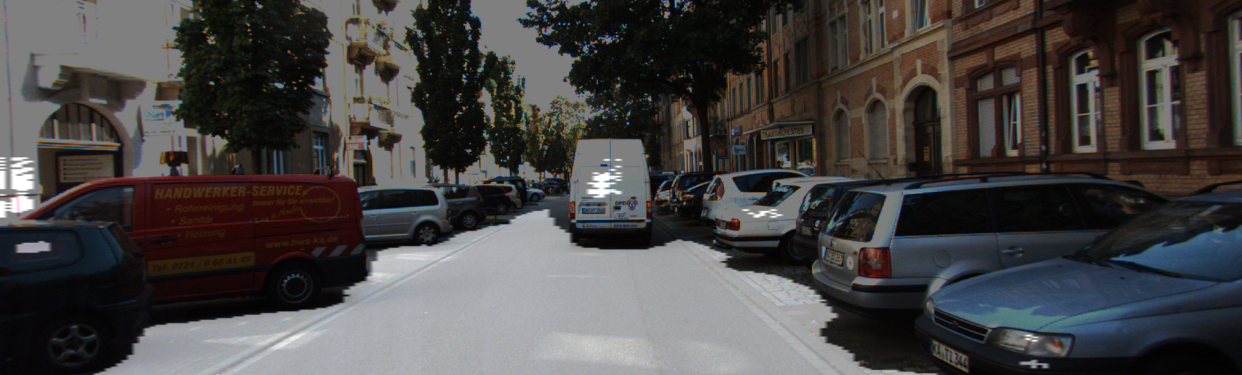

In [ ]:
# U-Net++
get_output(
     unetpp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
unet_iou = []
for i in range(20):
    output, prediction, target = get_output(unet_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unet_iou.append(calculate_iou_score(target, prediction))

IoU : 0.169192
IoU : 0.419641
IoU : 0.584087
IoU : 0.571212
IoU : 0.560296
IoU : 0.647032
IoU : 0.096767
IoU : 0.682226
IoU : 0.382736
IoU : 0.417902
IoU : 0.396688
IoU : 0.339661
IoU : 0.312324
IoU : 0.427770
IoU : 0.483619
IoU : 0.633674
IoU : 0.650405
IoU : 0.620941
IoU : 0.238317
IoU : 0.496165


In [ ]:
unetpp_iou = []
for i in range(20):
    output, prediction, target = get_output(unetpp_model, 
                                            test_preproc, 
                                            image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
                                            output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
                                            label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
                                           )
    unetpp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.671188
IoU : 0.803074
IoU : 0.717816
IoU : 0.627296
IoU : 0.709349
IoU : 0.712530
IoU : 0.550381
IoU : 0.748694
IoU : 0.588962
IoU : 0.554076
IoU : 0.741609
IoU : 0.702000
IoU : 0.553639
IoU : 0.652594
IoU : 0.744187
IoU : 0.850761
IoU : 0.844509
IoU : 0.841297
IoU : 0.627628
IoU : 0.696963


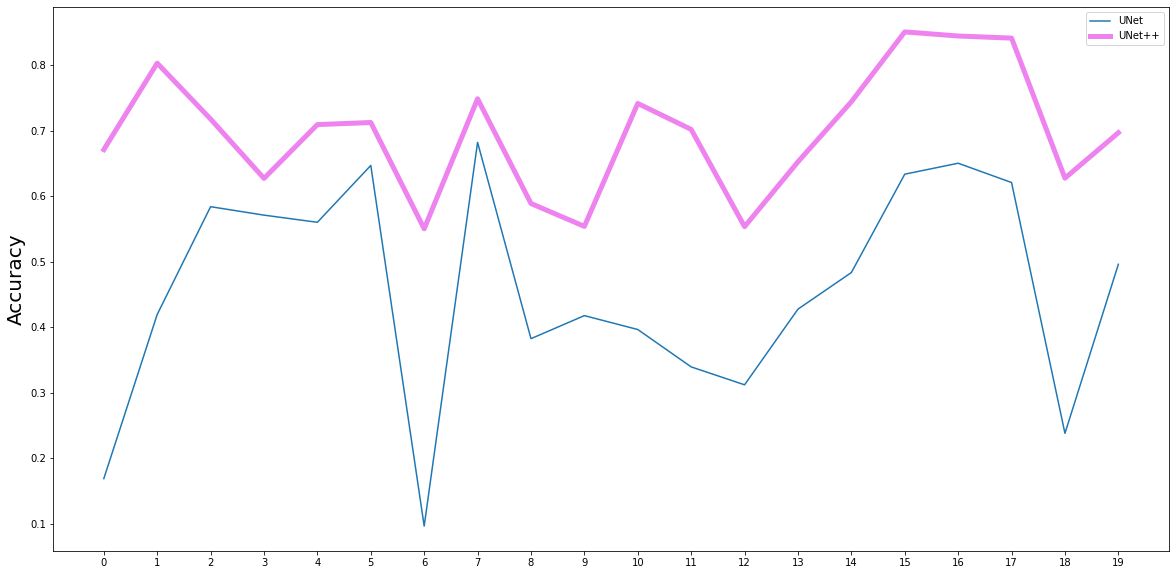

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(unet_iou, label='UNet',)
plt.plot(unetpp_iou, label='UNet++', color = 'violet' ,linewidth='4')
plt.ylabel('Accuracy', size=20)
plt.xticks(range(20), range(20))
plt.legend()

### Conclusion


---
- 결과 : 
  - u-net ++ 가 시각적으로 u-net 보다 훨씬 도로 영역을 상세하게 잘 찾았다
  - IoU 도 u-net++ 가 거의 두배 가까이 높게 나오는 모습을 확인 했다 

- 단순히 semantic segmentation 뿐 아니라, segmentation 을 위한 u-net 과 u-net++ 에 대해서 자세히 확인 해 볼 수 있었다 
- resnet 을 한번 해봤다고 인지, 부담스럽고 어렵게만 느껴지던 논문 구현이 한층 수월하게 느껴졌다 (실제로 조금 더 간단한 구조 인 것 같기도 하다)
- 논문 원본을 처음부터 끝까지 다 읽어 보지는 못해서 꼭 다시한번 처음부터 읽어 보아야겠다
- 특히 dropout 유무에 차이에 대해서 조금 더 알아보아야 할 것 같다 
- 특성 맵에 대한 개념이 아직까지 모호했는데 이번 프로젝트를 통해 조금은 감이 온 것 같다